<a href="https://colab.research.google.com/github/hentzrafael/resnet50-illegal-mining/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação das bibliotecas necessárias**


In [ ]:
from keras import layers, models, callbacks, metrics,Input,optimizers
import keras.utils as kutils
from keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping

#Image manipulating
from keras.preprocessing import image
from keras.models import load_model
import PIL
from PIL import ImageOps


from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, f1_score
import tqdm


# **Constantes**


In [ ]:
DATASET_REPO = 'drive/MyDrive/cienciaDadosDataset'
BATCH_SIZE=32

# **Criação dos datasets de treino, validação e teste**

O dataset possuía inicialmente 702 imagens. Dessas imagens, 20% foram separadas para o dataset de teste, para que o modelo não conheça as imagens que não sofrem normalização.

Foram criados outros dois subsets, treino - com 70% das imagens - e validação - com o restante 10%. Nestes dois datasets foi feita a normalização das imagens com base no desvio padrão e a média do dataset ImageNet.

In [ ]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])


def norm(img):
  img = (img - mean)/std
  return img


datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      preprocessing_function=norm,
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.1,
)


train_generator = datagen.flow_from_directory(
    DATASET_REPO+'/train',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset='training',
    seed=123
)

validation_generator = datagen.flow_from_directory(
    DATASET_REPO+'/train',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset='validation'
)

test_datagen = ImageDataGenerator(
      preprocessing_function=norm,
)


test_generator = test_datagen.flow_from_directory(
    DATASET_REPO+'/test',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    batch_size=BATCH_SIZE,
)


Found 506 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


## **Importação do modelo pré-treinado**

In [ ]:
input_t = Input(shape=(224,224,3))
res_model = ResNet50(include_top=False,
                    weights="imagenet",
                     input_tensor=input_t,

                     )

# Congelamento das camadas do modelo
for layer in res_model.layers[:140]:
  layer.trainable = False

# **Criação de modelo CNN**
A rede neural será criada usando o Keras e utilizará da tecnologia CNN para seu funcionamento.

O modelo será criado utilizando o modelo Sequential do keras, onde é necessário apenas informar as diferentes camadas que o modelo de Rede Neural terá.

In [ ]:
model = models.Sequential()
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1,activation='sigmoid'))

# **Treinando o modelo**

Para treinar o modelo serão utilizadas as imagens contidas no dataset de treinamento.

Algumas configurações para otimizar o processo de treinamento e escolha do melhor modelo treinado foram feitas.

O modelo é compilado usando como loss function *binary_crossentropy*, visto que a saída do modelo compreende apenas duas classes.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(
                  learning_rate=0.0001
              ),
              metrics=[
                  'accuracy',
                       ])

checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

hist = model.fit(train_generator,
        steps_per_epoch=506 // BATCH_SIZE,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=56 // BATCH_SIZE,
        callbacks=[checkpoint,early])

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9937
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 43s 2s/step - loss: 0.0456 - accuracy: 0.9937 - val_loss: 0.8322 - val_accuracy: 0.6875
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9831
Epoch 2: val_accuracy did not improve from 0.68750
15/15 [==============================] - 27s 2s/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 1.6205 - val_accuracy: 0.6875
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9875
Epoch 3: val_accuracy improved from 0.68750 to 0.78125, saving model to best_model.h5
15/15 [==============================] - 29s 2s/step - loss: 0.0701 - accuracy: 0.9875 - val_loss: 0.8682 - val_accuracy: 0.7812
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9916
Epoch 4: val_accuracy improved from 0.78125 to 0.93750, saving model to best_model.h5
15/15 [==============================] - 31s 2s/step - loss: 0.0447 - accuracy: 0.9916 - val_loss: 0.2725 - 

# **Métricas do modelo**
Para avaliar o desempenho do modelo, devemos fazer com que o dataset de teste não esteja mais separado em batches.
Após isso é feita a predição dos resultados para uso em métricas.

In [ ]:
test_generator.reset()
X_test, y_test = next(test_generator)
for i in tqdm.tqdm(range(int(test_generator.n/BATCH_SIZE)-1)):
  img, label = next(test_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)

y_pred = model.predict(X_test)

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


4/4 [==============================] - 1s 115ms/step


O modelo foi avaliado levando em conta a ROC curve, Sensitivity, Specificity, F1 e Precision Scores.

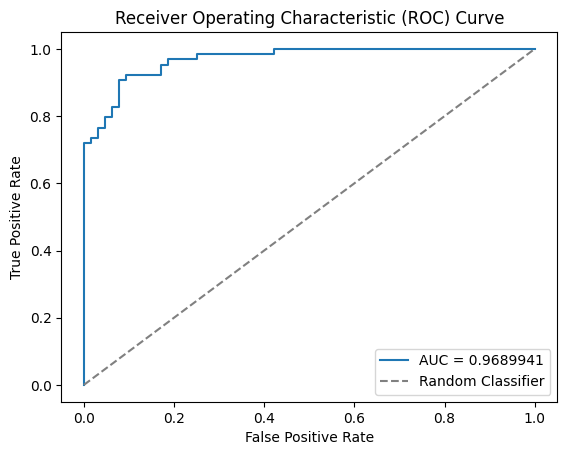

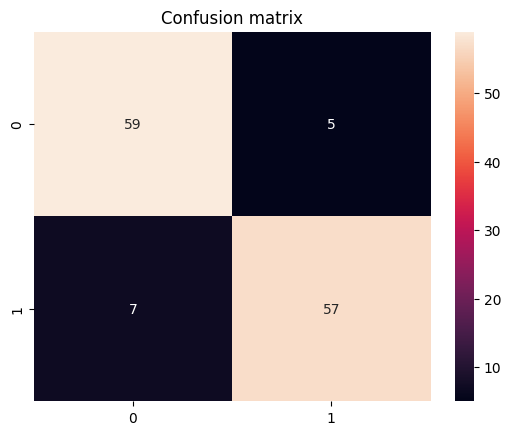

AUC: 0.9690
Sensitivity: 0.8906
Specificity: 0.9219
F1-score: 0.9048
Precision: 0.9194


In [ ]:
import seaborn as sn
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
model.save_weights(str(auc_score)+'_model.h5')
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]

binary_y_pred = np.where(y_pred <= optimal_threshold, 0 ,1)
binary_y_pred = binary_y_pred.astype('float32')
tn, fp, fn, tp = confusion_matrix(y_test,binary_y_pred).ravel()

# # Calculate sensitivity (true positive rate)
sensitivity = tp / (tp + fn)

# # Calculate specificity (true negative rate)
specificity = tn / (tn + fp)

# # Calculate F1-score
f1 = f1_score(y_test,binary_y_pred)

# # Calculate precision
precision = precision_score(y_test,binary_y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.7f}")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()
print()

sn.heatmap(confusion_matrix(y_test,binary_y_pred),annot=True)
plt.title("Confusion matrix")
plt.show()

print("AUC: {:.4f}".format(auc_score))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))
print("F1-score: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))

# **Métricas**

Função para plotagem de gráfico comparando o histórico de acurácia e loss conforme o modelo realizava os ciclos sobre o dataset.

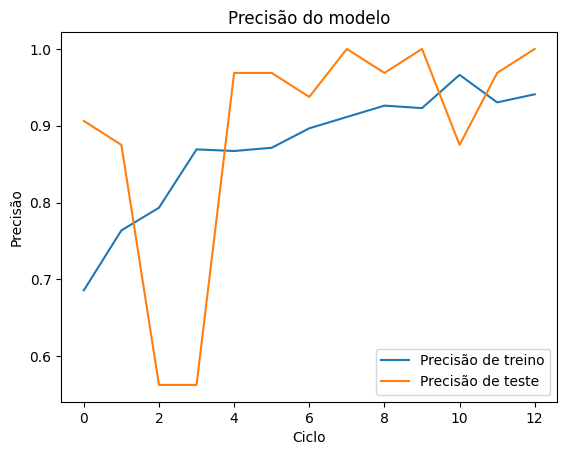

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Precisão do modelo")
plt.ylabel("Precisão")
plt.xlabel("Ciclo")
plt.legend(["Precisão de treino","Precisão de teste"])

plt.show()